## 1) Préparation

In [11]:
###############################################################################
## PARTIE SAM :
###############################################################################
## SAM : "The code requires python>=3.8, as well as pytorch>=1.7 and torchvision>=0.8"
# git clone https://github.com/facebookresearch/segment-anything.git SAM
# sed -i "s/torch.load(f)/torch.load(f, weights_only=True)/g" SAM/segment_anything/build_sam.py

# git clone https://github.com/facebookresearch/sam2.git SAM2

import os
import sys
import numpy as np
import torch

IA_AGENT_SAM_FOLDER = "SAM"
# IA_AGENT_SAM_CHECKPOINT_FOLDER = os.path.join(IA_AGENT_SAM_FOLDER, "weight")
IA_AGENT_SAM_CHECKPOINT_FOLDER = "checkpoints"
sys.path.append(IA_AGENT_SAM_FOLDER)
from SAM.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

device = "cuda" if torch.cuda.is_available() else "cpu"
SAM_URL = {
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",  # 2.39G
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",  # 1.2G
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",  # 358M
}

def load_sam(model_type: str = "vit_h", model_dir: str = "weight") -> torch.nn.Module:
    """Charge SAM soit à partir du disque soit en le téléchargeant.

    Utilise un hack en utilisant une fonction de Torch (`torch.hub.load_state_dict_from_url`)
    pour déléguer la bonne présence des poids sinon de les télécharger. Mais
    comme cela s'occupe uniquement des poids, le modèle n'est pas construit.
    D'où la suppression en mémoire des poids avant de charger SAM correctement,
    afin d'éviter d'avoir les poids 2 fois en mémoire.

    :param (str) model_type:    le type de model SAM
    :param (str) model_dir:     le dossier où sont les poids
        si le dossier ou les poids n'existent pas, ils sont téléchargés dedans
    :return (segment_anything.modeling.sam.Sam):    le modèle SAM demandé
    """
    # 1-Vérification présence des poids sinon téléchargement
    url = SAM_URL.get(model_type, SAM_URL["vit_h"])
    # model = torch.utils.model_zoo.load_url(url, model_dir=model_dir, weights_only=True)
    try:
        model = torch.hub.load_state_dict_from_url(url, model_dir=model_dir, weights_only=True)
    except:  # ancienne version de Torch
        model = torch.hub.load_state_dict_from_url(url, model_dir=model_dir)
    del model

    # 2-Création et chargement de SAM en mémoire demandée
    checkpoint_path = os.path.join(model_dir, os.path.basename(url))
    model = sam_model_registry[model_type](checkpoint=checkpoint_path)

    return model

model = load_sam("vit_b", model_dir=IA_AGENT_SAM_CHECKPOINT_FOLDER)
# pour celui-ci peut-être pas besoin CUDA (comme image encoder dans AnomaliGPT)
model = model.to(device)


In [3]:
###############################################################################
## PARTIE NOTEBOOK :
###############################################################################
import base64
import io
import os
from urllib.request import Request, urlopen
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# JUPITER NOTEBOOK :
from jupyter_bbox_widget import BBoxWidget


def recup_test_img():
    url = "https://media.roboflow.com/notebooks/examples/dog.jpeg"
    filename = os.path.basename(url)
    if not os.path.exists(filename):
        print("Fichier non présent, téléchargement.")
        req = Request(url, headers={"User-Agent": "torch.hub"})
        u = urlopen(req)
        file_size = None
        meta = u.info()
        if hasattr(meta, "getheaders"):
            content_length = meta.getheaders("Content-Length")
        else:
            content_length = meta.get_all("Content-Length")
        if content_length is not None and len(content_length) > 0:
            file_size = int(content_length[0])
        img_data = u.read()
        filename = io.BytesIO(img_data)
    return Image.open(filename)

# helper function that loads an image before adding it to the widget
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

def plot_masks_grid(masks, grid_size=(1, 4), figsize=(16, 4), scores=None):
    num_masks = masks.shape[0]
    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    for i in range(rows * cols):
        ax = axs[i]
        if i < num_masks:
            ax.imshow(masks[i], cmap="gray")
            tmp_title = f"Mask {i+1}"
            if scores is not None:
                tmp_title += f", score={scores[i]:.3f}"
            ax.set_title(tmp_title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def plot_seg_img(image_rgb, box_or_points, mask, title="", size=20):
    # 1. Copier l'image d'entrée
    image_with_box = image_rgb.copy()
    image_with_box = Image.fromarray(image_with_box)
    draw = ImageDraw.Draw(image_with_box)
    # 2. Dessiner rectangle ou point(s)
    if box_or_points.shape == (4,):  # C’est une box [x1, y1, x2, y2]
        x1, y1, x2, y2 = box_or_points
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
    elif box_or_points.ndim == 2 and box_or_points.shape[1] == 2:
        for x, y in box_or_points:
            draw.circle((x, y), radius=size, fill="red", width="10")
    else:
        raise ValueError("Entrée inconnue : doit être une box (4,) ou points (N, 2)")
    # 3. Superposer le masque
    masked_image = image_rgb.copy()
    masked_image[~mask] = masked_image[~mask] // 4  # obscurcir le fond
    overlay_image = masked_image
    # 4. Extraire l’objet sur fond blanc
    white_background = np.ones_like(image_rgb) * 255  # fond blanc
    object_on_white = white_background.copy()
    object_on_white[mask] = image_rgb[mask]
    # 5. Affichage
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title)
    # Image + box
    axs[0].imshow(image_with_box)
    axs[0].set_title("Image + boîte")
    axs[0].axis("off")
    # Image + masque
    axs[1].imshow(overlay_image)
    axs[1].set_title("Masque appliqué")
    axs[1].axis("off")
    # Objet seul
    axs[2].imshow(object_on_white)
    axs[2].set_title("Objet segmenté (fond blanc)")
    axs[2].axis("off")
    plt.tight_layout()
    plt.show()

# Function that inputs the output and plots image and mask
def show_output(result_dict, axes=None):
     if axes:
        ax = axes
     else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
     sorted_result = sorted(result_dict, key=(lambda x: x['area']), reverse=True)
     # Plot for each segment area
     for val in sorted_result:
        mask = val['segmentation']
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, mask*0.5)))


image_PIL = recup_test_img()
# fig = plt.figure()
# ax = fig.add_subplot()
# _ = ax.imshow(image_PIL)
# _ = ax.axis("off")
# plt.show()

## 2) SAM en BOX

In [4]:
###############################################################################
## PARTIE NOTEBOOK :
###############################################################################
IS_COLAB = False  # <=============== POUR COLAB !!!!!!!!!!

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()


widget = BBoxWidget()
# widget.image = encode_image(IMAGE_PATH)
bytes_io = io.BytesIO()
image_PIL.save(bytes_io, format='jpeg')
widget.image_bytes = bytes_io.getvalue()
widget


BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [5]:
###############################################################################
## PARTIE NOTEBOOK :
###############################################################################
# 2. Créer la box [x1, y1, x2, y2]
box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
if len(widget.bboxes) != 0:
    box = widget.bboxes[0]
box_np = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])
print(widget.bboxes)
print(box_np)
print(image_PIL)


[]
[ 68 247 623 925]
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x1280 at 0x1F02F864440>


In [12]:
###############################################################################
## PARTIE SAM :
###############################################################################
# 1. Charger et convertir l'image
# S'assurer que l’image est en mode RGB (au cas où ce serait une image en L, RGBA, etc.)
image_PIL = image_PIL.convert("RGB")
image_rgb = np.array(image_PIL)

# 2. Créer/récupérer la box [x1, y1, x2, y2]
box_np

# 3. Prédire avec SAM
mask_predictor = SamPredictor(model)
mask_predictor.set_image(image_rgb)
masks, scores, logits = mask_predictor.predict(
    box=box_np,
    multimask_output=False,
)
mask = masks[0]  # shape: (H, W), bool

masks3, scores3, logits3 = mask_predictor.predict(
    box=box_np,
    multimask_output=True,
)
mask3 = masks3[np.argmax([np.sum(x) for x in scores3])]  # choix par score
# mask3 = masks3[np.argmax([np.sum(x) for x in masks3])]  # choix par taille

# 18s

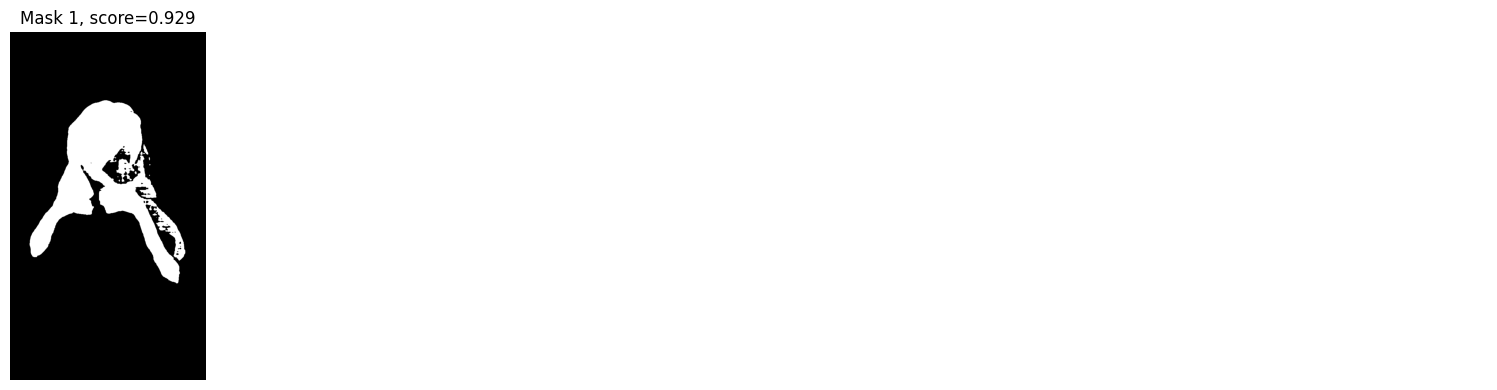

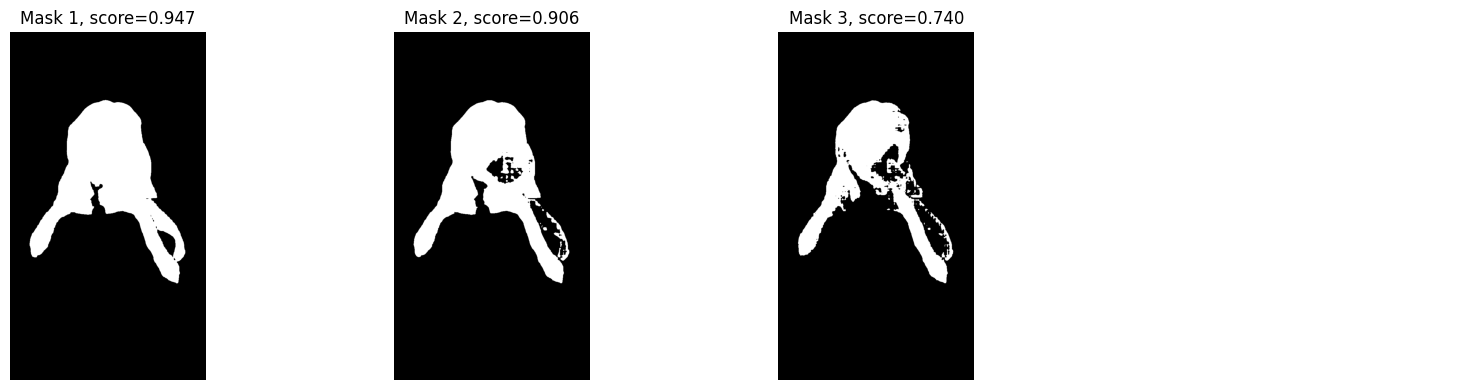

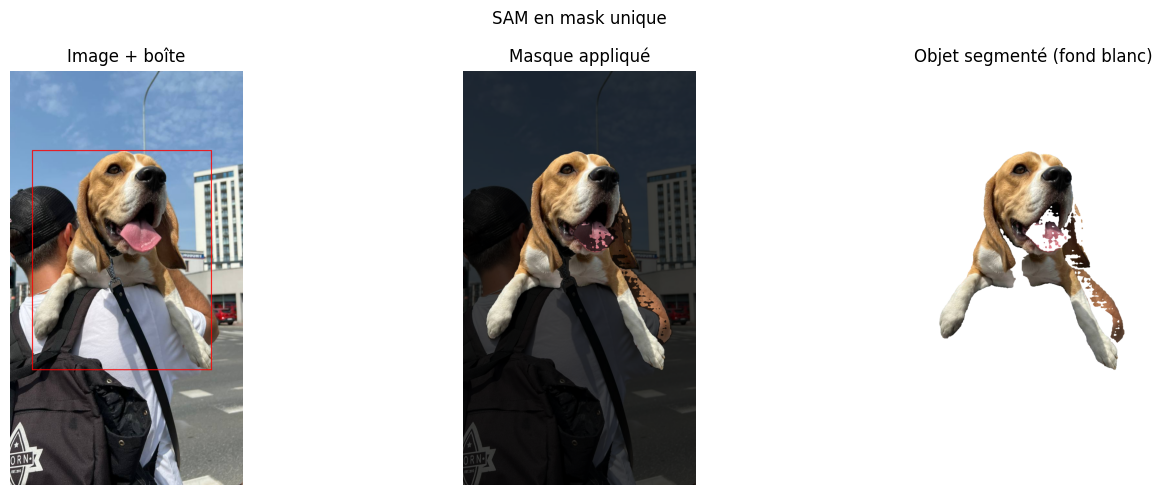

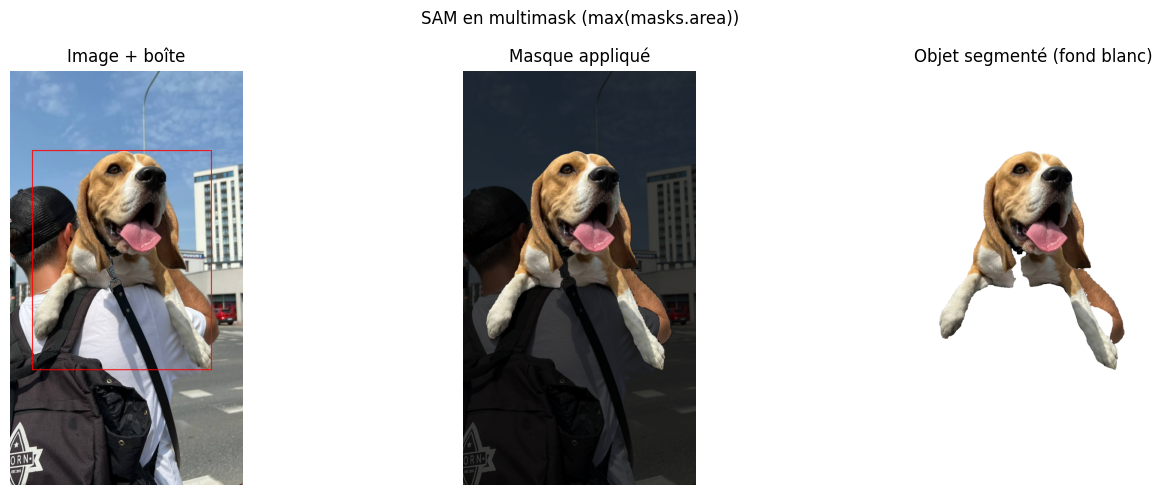

In [8]:
###############################################################################
## PARTIE NOTEBOOK :
###############################################################################
plot_masks_grid(masks, grid_size=(1, 4), figsize=(16, 4), scores=scores)
plot_masks_grid(masks3, grid_size=(1, 4), figsize=(16, 4), scores=scores3)
plot_seg_img(image_rgb, box_np, mask, "SAM en mask unique")
plot_seg_img(image_rgb, box_np, mask3, "SAM en multimask (max(masks.area))")


## 3) SAM en MASK

In [90]:
###############################################################################
## PARTIE SAM :
###############################################################################
# 1. Charger et convertir l'image
# S'assurer que l’image est en mode RGB (au cas où ce serait une image en L, RGBA, etc.)
image_PIL = image_PIL.convert("RGB")
image_rgb = np.array(image_PIL)

# 2. Prédire avec SAM
mask_generator = SamAutomaticMaskGenerator(model)
sam_result = mask_generator.generate(image_rgb)
print(len(sam_result))
print(sam_result[0].keys())  # par mask

# => python scripts/amg.py --checkpoint <path/to/checkpoint> --model-type <model_type> --input <image_or_folder> --output <path/to/output>

#3m

47
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


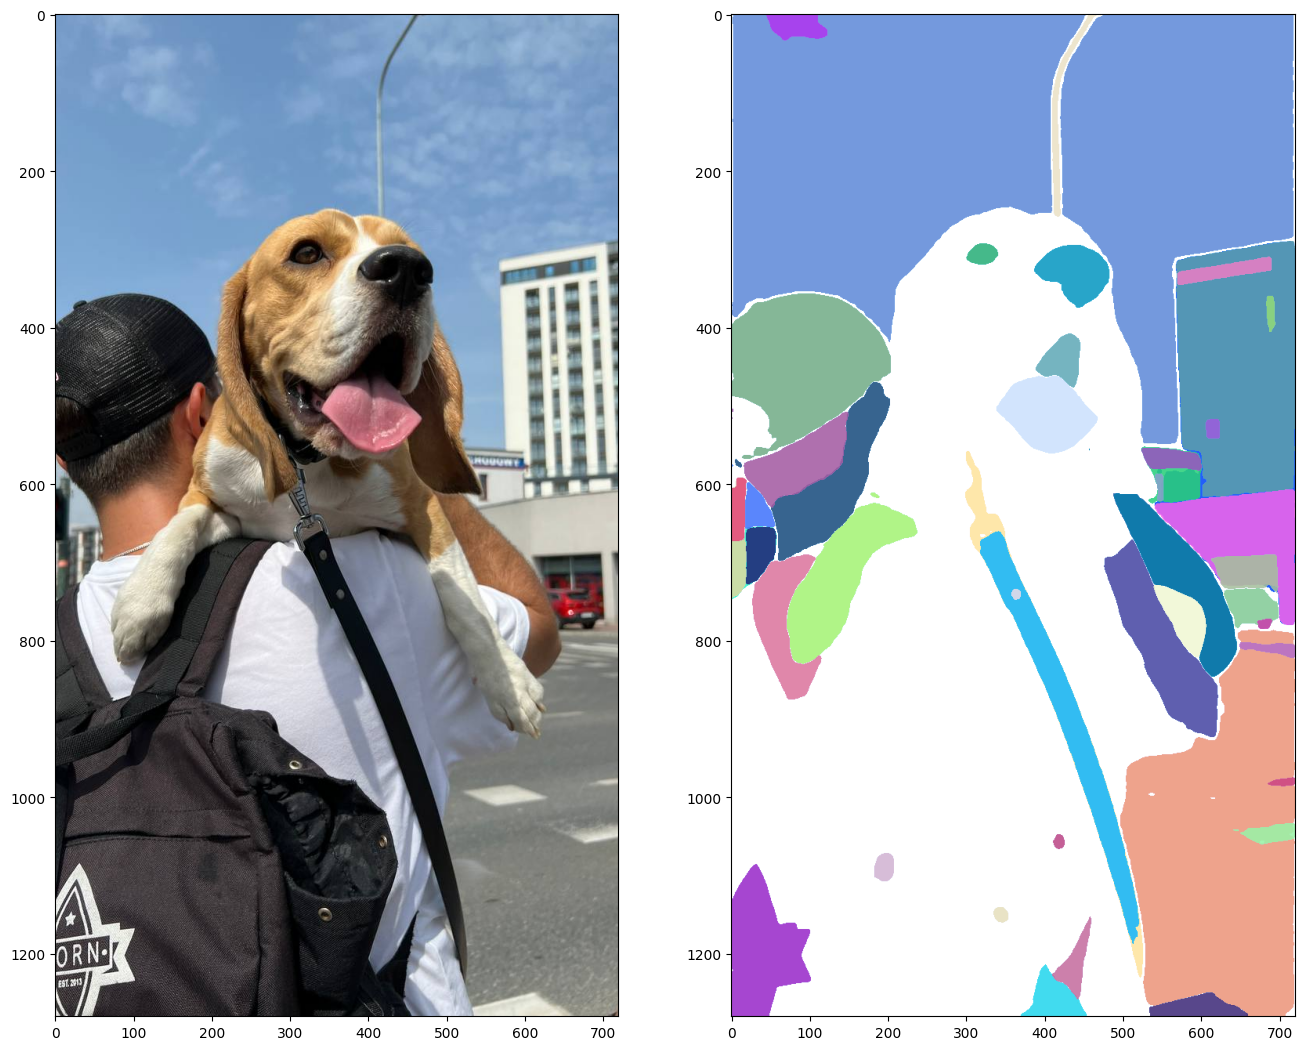

In [88]:
###############################################################################
## PARTIE NOTEBOOK :
###############################################################################
_,axes = plt.subplots(1,2, figsize=(16,16))
axes[0].imshow(image_rgb)
show_output(sam_result, axes[1])


## 4) SAM en POINT

In [13]:
###############################################################################
## PARTIE NOTEBOOK :
###############################################################################
widget = BBoxWidget()
bytes_io = io.BytesIO()
image_PIL.save(bytes_io, format='jpeg')
widget.image_bytes = bytes_io.getvalue()
widget


BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [99]:
###############################################################################
## PARTIE NOTEBOOK :
###############################################################################
# 2. Créer le point [x1, y1]
box = {'x': 400, 'y': 364, 'width': 0, 'height': 0, 'label': ''}
if len(widget.bboxes) != 0:
    box = widget.bboxes[0]
input_point = np.array([[
    box['x'],
    box['y'],
]])
print(widget.bboxes)
print(input_point)
print(image_PIL)

input_label = np.array([1])

[{'x': 400, 'y': 364, 'width': 0, 'height': 0, 'label': ''}]
[[400 364]]
<PIL.Image.Image image mode=RGB size=720x1280 at 0x1CE8B8686E0>


In [107]:
###############################################################################
## PARTIE SAM :
###############################################################################
# 1. Charger et convertir l'image
# S'assurer que l’image est en mode RGB (au cas où ce serait une image en L, RGBA, etc.)
image_PIL = image_PIL.convert("RGB")
image_rgb = np.array(image_PIL)

# 2. Créer/récupérer les points [x1, y1]
input_point

# 3. Prédire avec SAM
mask_predictor = SamPredictor(model)
mask_predictor.set_image(image_rgb)
masks_p, scores_p, logits_p = mask_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)
mask_p = masks_p[0]  # shape: (H, W), bool

masks3_p, scores3_p, logits3_p = mask_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
mask3_p = masks3_p[np.argmax([np.sum(x) for x in scores3_p])]  # choix par score
# mask3_p = masks3_p[np.argmax([np.sum(x) for x in masks3_p])]  # choix par taille

# 18s

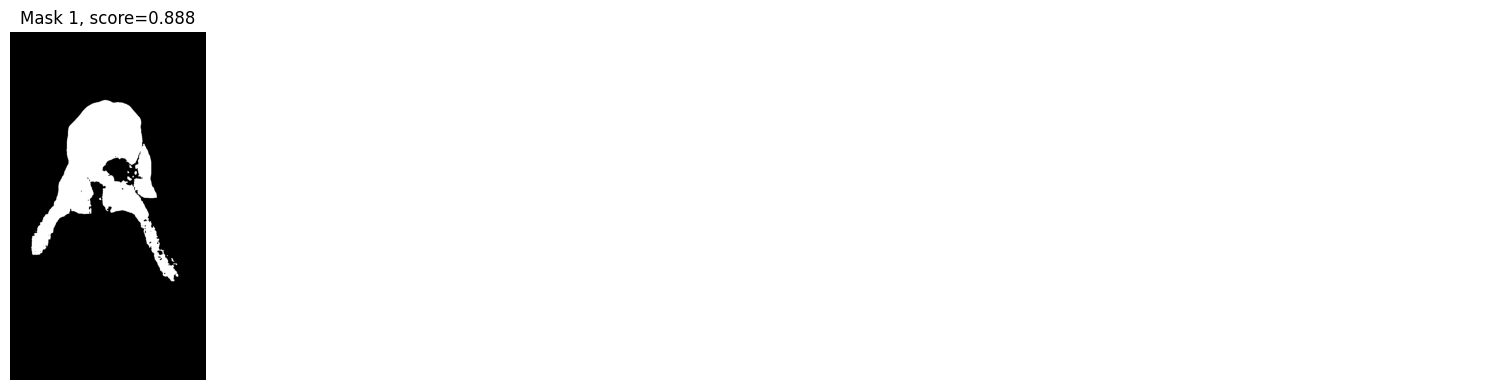

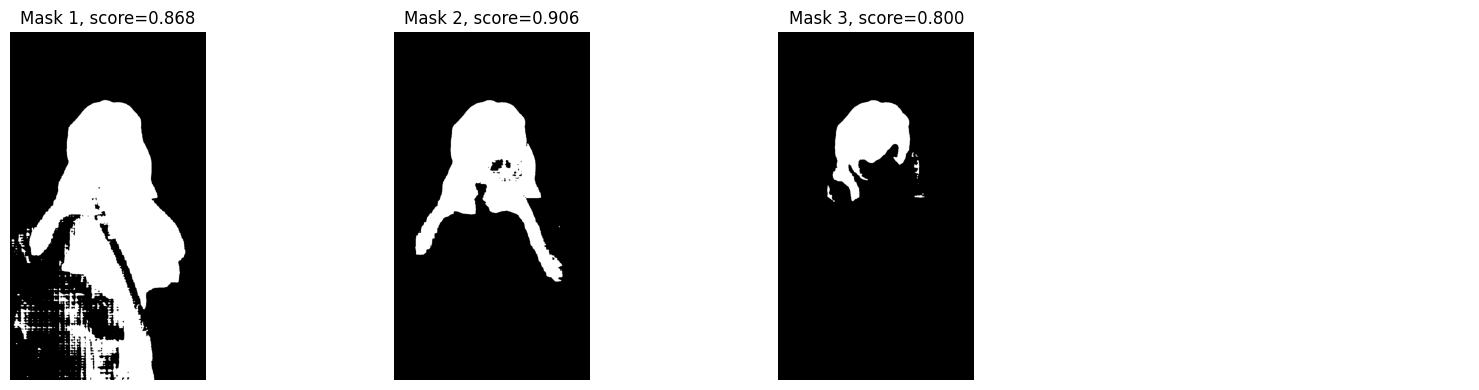

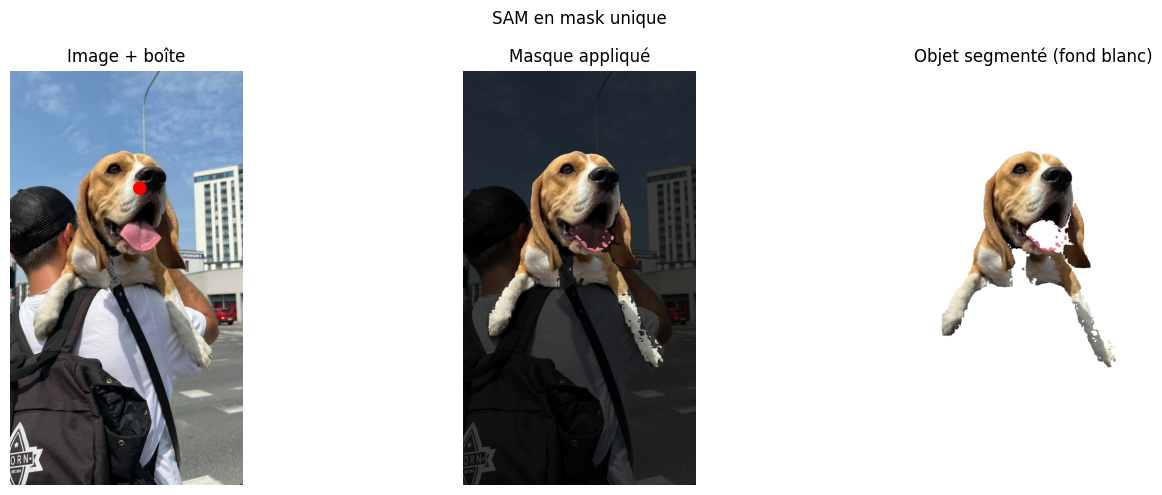

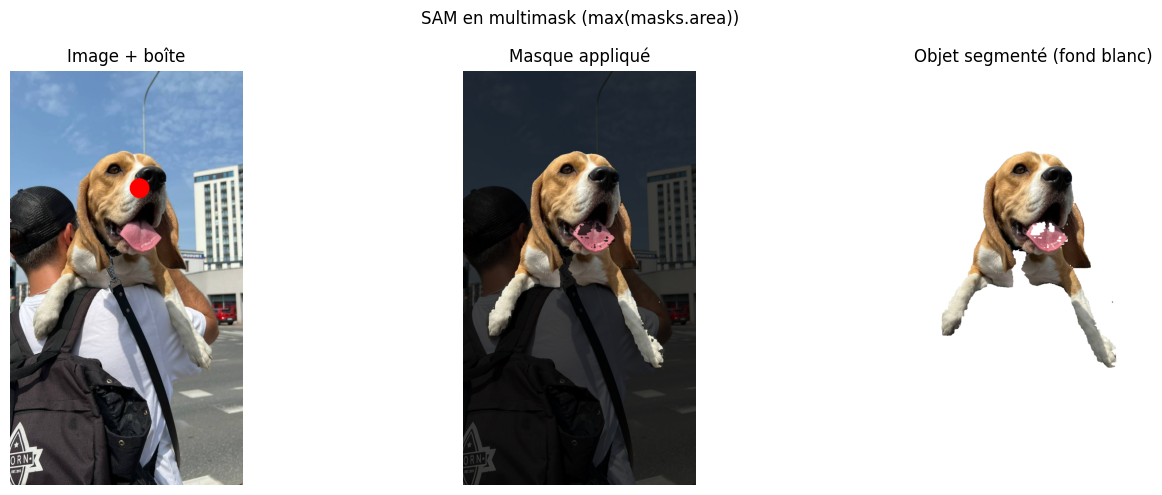

In [ ]:
###############################################################################
## PARTIE NOTEBOOK :
###############################################################################
plot_masks_grid(masks_p, grid_size=(1, 4), figsize=(16, 4), scores=scores_p)
plot_masks_grid(masks3_p, grid_size=(1, 4), figsize=(16, 4), scores=scores3_p)
plot_seg_img(image_rgb, input_point, mask_p, "SAM en mask unique", size=20)
plot_seg_img(image_rgb, input_point, mask3_p, "SAM en multimask (max(masks.area))", size=30)



#https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb#scrollTo=NGxKHiK2uqtE
